# Practical 7: Training model using script mode


 
### Fashion MNIST data

The dataset contains 60,000 small square 28 $\times$ 28 pixel grayscale images of 10 types of clothing:

- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot


**Our tasks are**
- **To construct a simple MLP to classify the type of clothing using Keras & Tensorflow** 
- **To write a Python script to train a MLP in a local machine**


### Load Keras, TensorFlow and other package 

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.datasets import fashion_mnist
import numpy as np 
from matplotlib import pyplot 
import subprocess

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy

In [3]:
tf.__version__, keras.__version__ #Check versions of tensorflow & keras

('2.9.1', '2.9.0')

### Download Fashion MNIST data from Keras 

In [4]:
(x_train,y_train), (x_val,y_val)  = fashion_mnist.load_data()

In [5]:
#Each image is represented as a 28x28 pixel grayscale images
## View shape and type of data
print("x_train_shape", x_train.shape)
print("x_train_type", x_train.dtype)
print("x_test_shape", x_val.shape)


x_train_shape (60000, 28, 28)
x_train_type uint8
x_test_shape (10000, 28, 28)


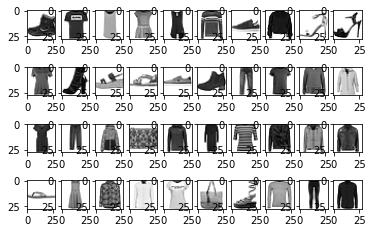

In [6]:
## view some of the data by plotting a few of the raw pixel data as images
n_rows = 4
n_cols = 10
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols*row +col
        pyplot.subplot(n_rows,n_cols,index+1)
        pyplot.imshow(x_train[index], cmap="binary")

### A simple structure of MLP
![title](NN.png)

### Build a MLP

#### Steps needed 

1. *Shape:* ensuring the dataset have the right shape for TensorFlow
2. *Normalisation:* normalising the data, *i.e.* tranform [0-255] pixels values to [0-1] value
3. *One-Hot Encode Class Labels:* convert category labels using one-hot encoding
4. *Building the model:* build a sequential model in Keras
5. *Training:* train the model
6. *Test:* test the model and make predictions 

#### Steps 1, 2 & 3: Shape, Normalise and One Hot Encoding 

In [7]:

x_train = x_train.astype('float32')/255
x_val = x_val.astype('float32')/255

num_class = 10
y_train = to_categorical(y_train, num_class)
y_val = to_categorical(y_val,num_class)

#### Step 4: Building a sequential VNN model in Keras 

Note: First we will go thorugh building the model on a local machine. Next, we will go through how to run in a script to prepare for using AWS in Week 2

We will build a VNN with the following structure:

- Number of Hidden layers = 2: The first hidden layer contains 64 neurons while the second layer includes 32 neurons. 
- Activation function: Both hidden layers will use the Relu activation function
- Optimizer: Stochastic Gradient Descent

In [8]:

model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28, 1]),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(num_class, activation="softmax")
    ])
model.compile(loss=categorical_crossentropy,
                  optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
                  metrics=['accuracy',
                           keras.metrics.Precision(),
                           keras.metrics.Recall()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


c:\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


#### Step 5: Training the model 

Now we are ready to train the model

In [9]:
# train model
history = model.fit (x_train, y_train, batch_size=128,
 validation_split=0.1, epochs=5)

Epoch 1/5
422/422 [==============================] - 3s 5ms/step - loss: 0.6561 - accuracy: 0.7732 - precision: 0.8629 - recall: 0.6729 - val_loss: 0.4658 - val_accuracy: 0.8358 - val_precision: 0.8736 - val_recall: 0.7880
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 0.4497 - accuracy: 0.8407 - precision: 0.8790 - recall: 0.8004 - val_loss: 0.4325 - val_accuracy: 0.8462 - val_precision: 0.8810 - val_recall: 0.8067
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 0.4078 - accuracy: 0.8564 - precision: 0.8887 - recall: 0.8224 - val_loss: 0.3966 - val_accuracy: 0.8547 - val_precision: 0.8833 - val_recall: 0.8240
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 0.3824 - accuracy: 0.8640 - precision: 0.8934 - recall: 0.8353 - val_loss: 0.4028 - val_accuracy: 0.8498 - val_precision: 0.8815 - val_recall: 0.8245
Epoch 5/5
422/422 [==============================] - 2s 4ms/step - loss: 0.3638 - accuracy: 0.8703 - precisi

#### Step 6: Testing the model 

- Evaluating the performance of the model 

In [10]:
score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss    :', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])

Test loss    : 0.405424028635025
Test accuracy: 0.8549000024795532
Test precision: 0.8818520307540894


### Running the model using the Python script

We are now going to learn how to write a Python script so that we can easily train the model on AWS SageMaker. To do that we need to parse some [AWS environment variables](https://github.com/aws/sagemaker-containers#list-of-provided-environment-variables-by-sagemaker-containers) 
 
**Why are these environment variables important?** 
- They will be automatically passed to our script by AWS SageMaker, so that Sagemaker can find where the data sets are, where to save the model, and how many GPUs we have. 
- In other words, the step is to ensure that we do not change the code much when training and deploying the model on AWS.


In [11]:
# %%sh
# pygmentize mnist_MLP_tf2.py

In [12]:
(x_train,y_train), (x_val,y_val)  = fashion_mnist.load_data()
os.makedirs("./data", exist_ok=True) #exist_ok = True means no error if directory already exists
np.savez('./data/training', image = x_train, label=y_train) #save the training data into a folder called training
np.savez('./data/test', image=x_val, label=y_val) #save the test data into a folder called test
os.makedirs(os.getcwd() + "./output", exist_ok=True) #make a directory for the output  

Check if training and test data are upload to "data" folder using a magic shell command

In [13]:
process = subprocess.Popen(["dir", "data"], shell=True, cwd=os.getcwd(), stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
for line in process.stdout:
    print(line)

 Volume in drive G is Google Drive

 Volume Serial Number is 1983-1116



 Directory of g:\Other computers\My Computer (1)\Year 4\SP2\MA3832\Practicals\W7\data



07/09/2022  05:50 PM    <DIR>          .

07/09/2022  05:46 PM    <DIR>          ..

07/09/2022  05:50 PM        47,100,506 training.npz

07/09/2022  05:50 PM         7,850,506 test.npz

               2 File(s)     54,951,012 bytes

               2 Dir(s)   4,676,276,224 bytes free



In [14]:
# where to save the model
os.environ["SM_MODEL_DIR"] = os.getcwd() + "\output"

# where the training data is
os.environ["SM_CHANNEL_TRAINING"] = os.getcwd() + "\data"  

# where the test data is
os.environ["SM_CHANNEL_VALIDATION"] = os.getcwd() + "\data"

os.environ["SM_NUM_GPUS"] = "0"

subprocess.Popen(["rmdir", os.environ["SM_MODEL_DIR"]], shell=True, cwd=os.getcwd(), stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
process = subprocess.Popen(["python", "mnist_MLP_tf2.py", "--epochs 5"], shell=True, cwd=os.getcwd(), stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
for line in process.stdout:
    print("Log: " + line)
for errline in process.stderr:
    print("Error: " + errline)

Log: gpu_count: 0

Log: model_dir: g:\Other computers\My Computer (1)\Year 4\SP2\MA3832\Practicals\W7\output

Log: training_dir: g:\Other computers\My Computer (1)\Year 4\SP2\MA3832\Practicals\W7\data

Log: validation_dir: g:\Other computers\My Computer (1)\Year 4\SP2\MA3832\Practicals\W7\data

Log: x_train shape: (60000, 28, 28, 1)

Log: 60000 train samples

Log: 10000 test samples

Log: Epoch 1/10

Log: 

Log:   1/422 [..............................] - ETA: 12:57 - loss: 2.4222 - accuracy: 0.1172 - precision: 0.0000e+00 - recall: 0.0000e+00

Log:  12/422 [..............................] - ETA: 2s - loss: 2.1127 - accuracy: 0.2578 - precision: 0.0000e+00 - recall: 0.0000e+00   

Log:  26/422 [>.............................] - ETA: 1s - loss: 1.8229 - accuracy: 0.3663 - precision: 0.9672 - recall: 0.0355        

Log:  45/422 [==>...........................] - ETA: 1s - loss: 1.4999 - accuracy: 0.4948 - precision: 0.8805 - recall: 0.1675

Log:  65/422 [===>..........................] -

Load model

In [15]:
newmodel = tf.keras.models.load_model('output/1/')

In [16]:
newmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


In [17]:
score = newmodel.evaluate(x_val, y_val, verbose=0)
print('Test loss    :', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])

ValueError: in user code:

    File "c:\Python310\lib\site-packages\keras\engine\training.py", line 1557, in test_function  *
        return step_function(self, iterator)
    File "c:\Python310\lib\site-packages\keras\engine\training.py", line 1546, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Python310\lib\site-packages\keras\engine\training.py", line 1535, in run_step  **
        outputs = model.test_step(data)
    File "c:\Python310\lib\site-packages\keras\engine\training.py", line 1501, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Python310\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "c:\Python310\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Python310\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Python310\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Python310\lib\site-packages\keras\losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Python310\lib\site-packages\keras\backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible
